# What to expect from this kernel?

- Train_labels data (y)
- Train image data (X)
- CNN Models for Vowel, Consonant, Grapheme (Accu: 86%) 

Download the train data to directly train your own deep-learning or machine learning model. You can download the prepared training data from this kernel ( Link provided below).

### _Please upvote if you like it._
# Model flow

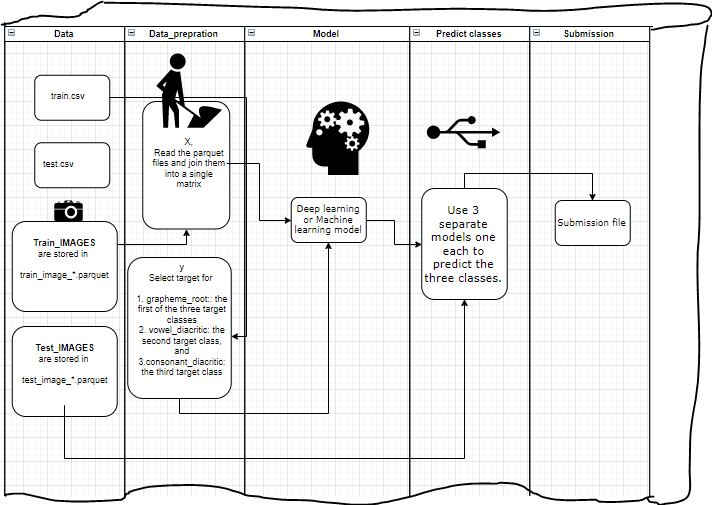



# Introduction
Bengali language origninated from the Prakrit or Middle Indo-Aryan, which is descended from Sanskrit. 
The map below shows Begali or Bangla speaking regions.
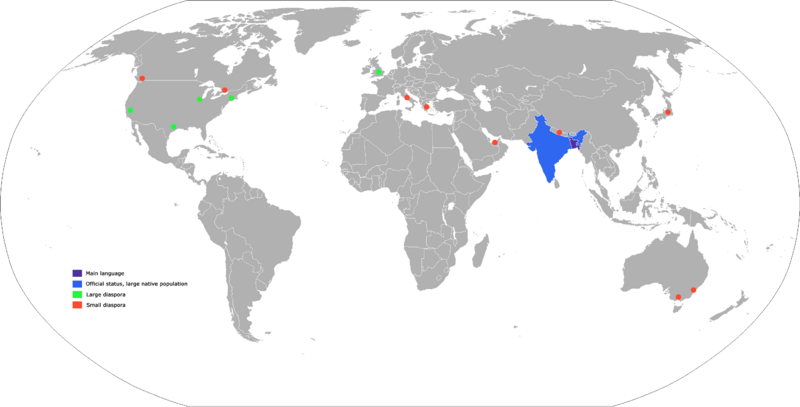






```Jana Gana Mana``` is the national anthem of India. 
It was first written in Bengali, it is the first of five stanzas of a poem written and later set to notations by novel loriat Rbindranath Tagore (1861-1941).

- Rabindranath Tagore won the Nobel Prize for Literature Language: Bengali; English) in 1913.


### Objective:
For this competition, you’re given the image of a handwritten Bengali grapheme and are challenged to separately classify three constituent elements in the image: grapheme root, vowel diacritics, and consonant diacritics.

Steps:
- Read train_label data and make it same as submission.csv file i.e. with only two columns. The image_id merge it with the three classes i.e. grapheme_root, vowel_diacritics, and consonant_diacritics e.g. Train_0_grapheme_root.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from PIL import Image

import dask.dataframe as dd
from tqdm.auto import tqdm
import cv2


In [ ]:
print(os.listdir("../input/bengaliai-cv19/"))

## File
### train.csv

- ```image_id:``` the foreign key for the parquet files
- ```grapheme_root:``` the first of the three target classes
- ```vowel_diacritic:``` the second target class
- ```consonant_diacritic:``` the third target class
- ```grapheme:``` the complete character. Provided for informational purposes only, you should not need to use this.

### test.csv

Every image in the test set will require three rows of predictions, one for each component. This csv specifies the exact order for you to provide your labels.
- ```row_id:``` foreign key to the sample submission 
- ```image_id:``` foreign key to the parquet file 
- ```component:``` the required target class for the row (grapheme_root, vowel_diacritic, or consonant_diacritic)

In [ ]:
df_train_labels = pd.read_csv("../input/bengaliai-cv19/train.csv")
df_train_labels.head()

In [ ]:
len(df_train_labels.grapheme_root.unique())

In [ ]:
len(df_train_labels.consonant_diacritic.unique())

In [ ]:
len(df_train_labels.vowel_diacritic.unique())

In [ ]:
df_train_labels.shape

In [ ]:
df_train_labels = df_train_labels.drop(['grapheme'], axis=1)

In [ ]:
df_train_labels.head()

In [ ]:
#df_train_labels.image_id.stack()
df_tmp = pd.melt(df_train_labels, id_vars=['image_id'], value_vars=['grapheme_root',	'vowel_diacritic',	'consonant_diacritic'])

In [ ]:
df_tmp.head()

In [ ]:
df_tmp[df_tmp['image_id']=='Train_0']

- Add a column name 'row_id' by combining image_id and variable column values.

In [ ]:
df_tmp['row_id'] = df_tmp['image_id']+'_'+df_tmp['variable']

In [ ]:
df_tmp.head()

- Rename the column-names i.e. 'variable' to 'component'.

In [ ]:
df_tmp= df_tmp.rename(columns={"variable": "component"}, errors="raise")

In [ ]:
df_test_labels = pd.read_csv("../input/bengaliai-cv19/test.csv")
df_test_labels.head()

- Make three separate dataframe each for 'compnent' ```consonant_discritic```, ```grapheme_root```, and ```vowel_diacritic```.

- These are the train_target values. i.e. the values in column 'value'.

In [ ]:
df_consonant = df_tmp[df_tmp['component'] =='consonant_diacritic']
df_grapheme = df_tmp[df_tmp['component'] =='grapheme_root']
df_vowel = df_tmp[df_tmp['component'] =='vowel_diacritic']

In [ ]:
print(df_consonant.shape)
print(df_grapheme.shape)
print(df_vowel.shape)

In [ ]:
df_consonant.head()

## Sneak peak at distribution of the three class

In [ ]:
sns.catplot(x="vowel_diacritic", data=df_train_labels, kind="count")

In [ ]:
sns.catplot(x="consonant_diacritic", data=df_train_labels, kind="count")

In [ ]:
sns.catplot(x="grapheme_root", data=df_train_labels, kind="count")

Let us look at some of the Bengali images

### Helper function to read and see parquet

In [ ]:
HEIGHT = 137
WIDTH = 236

def load_as_npa(file):
    df = pd.read_parquet(file)
    return df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)

In [ ]:
#images0 = load_as_npa('/kaggle/input/bengaliai-cv19/train_image_data_0.parquet')
#images1 = load_as_npa('/kaggle/input/bengaliai-cv19/train_image_data_1.parquet')
#images2 = load_as_npa('/kaggle/input/bengaliai-cv19/train_image_data_2.parquet')
#images3 = load_as_npa('/kaggle/input/bengaliai-cv19/train_image_data_3.parquet')


In [ ]:
#f, ax = plt.subplots(4, 4, figsize=(12, 8))
#ax = ax.flatten()

#for i in range(16):
#    ax[i].imshow(images0[i], cmap='Greys')

## Merge the 3 parquet image_matrix into one matrix

In [ ]:
#final_train_images = np.concatenate((images0, images1, images2, images3), axis=0)

### Free some memory. Here my memory usage was 13 Gb, after running the garbage collector, it reduced to 7 Gb.

In [ ]:
#del [[images0, images1, images2, images3, final_train_images]]
#del [[final_train_images]]
#gc.collect()

In [ ]:
#final_train_images.shape

Read each parquet file again



In [ ]:
#import pyarrow.parquet as pq

In [ ]:
#able = pq.read_table(file_path, nthreads=4)
#df_image_0 = pq.read_table('/kaggle/input/bengaliai-cv19/train_image_data_0.parquet')

In [ ]:
def resize(df, size=46, need_progress_bar=True):
    resized = {}
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    else:
        for i in range(df.shape[0]):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [ ]:
df_image_0 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_0.parquet')

In [ ]:
df_image_0.shape

In [ ]:
type(df_image_0)

In [ ]:
df_image_0.head()

In [ ]:
df_image_0 = df_image_0.iloc[:,1:]

In [ ]:
df_image_0 = resize(df_image_0)/255
#X_train = resize(X_train)/255

In [ ]:
X_image_0 = df_image_0.to_numpy() # Convert the dataframe to matrix 

In [ ]:
X_image_0.shape

In [ ]:
del [[df_image_0]]
gc.collect()

In [ ]:
df_image_1 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_1.parquet')
df_image_1= df_image_1.iloc[:,1:]

In [ ]:
df_image_1 = resize(df_image_1)/255

In [ ]:
X_image_1 = df_image_1.to_numpy() # Convert the dataframe to matrix 

In [ ]:
X_image_1.shape

In [ ]:
#del [[df_image_1]]
del df_image_1
gc.collect()

In [ ]:
df_image_2 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_2.parquet')
df_image_2= df_image_2.iloc[:,1:]

In [ ]:
df_image_2 = resize(df_image_2)/255

In [ ]:
X_image_2 = df_image_2.to_numpy() # Convert the dataframe to matrix 

In [ ]:
X_image_2.shape

In [ ]:
#del [[df_image_2]]
del df_image_2
gc.collect()

In [ ]:
df_image_3 = pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_3.parquet')
df_image_3= df_image_3.iloc[:,1:]

In [ ]:
df_image_3 = resize(df_image_3)/255

In [ ]:
X_image_3 = df_image_3.to_numpy() # Convert the dataframe to matrix 

In [ ]:
X_image_3.shape

In [ ]:
del [[df_image_3]]
gc.collect()

## Final data for training

Here, the ```final_train_images``` combines the image pixels with the three labels i.e. ```grapheme_root```, ```vowel_diacritic```, ```consonant_diacritic``` which can be used to train the model.

We will use this to train a model.

In [ ]:
#final_train_images

In [ ]:
#image_size = 137 * 236
#final_train_images.reshape(image_size)

In [ ]:
#X = final_train_images/255

In [ ]:
#X = pd.merge([X_image_0, X_image_1, X_image_2, X_image_3])
X= np.concatenate((X_image_0, X_image_1, X_image_2, X_image_3), axis=0)

In [ ]:
len(X)

In [ ]:
del X_image_0
del X_image_1
del X_image_2
del X_image_3
gc.collect()

# Saving the training data: Download

Here, following files are being saved:
- X ( It has all the training images, pixel in matrix format- each row in the matrix represents an image)

Additionally, the three target columns for three separate model one each for ```consonant_discritic```: 7, ```grapheme_root```: 168, and ``vowel_diacritic```: 11.

- ```df_consonant.shape```
- ```df_grapheme.shape``` and
- ```df_vowel.shape``` 

Each one will work as target for our three separte models.

In [ ]:
type(X)

In [ ]:
#from tempfile import TemporaryFile
#train_all_image_file = TemporaryFile()


#from joblib import dump
#dump(X, 'all_image_4_train.joblib', compress=3)
#import pickle
#f=open('all_image_4_train','w')
#pickle.dump(X, f, protocol=4)
#f.close()

In [ ]:
# Download form the output folder of thsi kernel
df_consonant.to_csv("target_4_consonant.csv")
df_grapheme.to_csv("target_4_grapheme.csv")
df_vowel.to_csv("target_4_vowel.csv")

```consonant_discritic```: 7, 

```grapheme_root```: 168, and 

```vowel_diacritic```: 11

#### Download the above files and load in your kernel before carryingout the below steps.

In [ ]:
#X.shape

In [ ]:
X= X.reshape(-1,46, 46,1)

## Model_consonant

In [ ]:
n_classes = 7

In [ ]:
y= df_consonant.value

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y = to_categorical(y, n_classes)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
#X = np.divide(X, 255)
#import dask.array as da

#X = np.arange(1000)  #arange is used to create array on values from 0 to 1000
#y = da.from_array(X, chunks=(100))  #converting numpy array to dask array

#y.div(255).compute()  #computing mean of the array

In [ ]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras import Sequential

In [ ]:
model_consonant = Sequential()

model_consonant .add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(46, 46,1)))

model_consonant .add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_consonant .add(MaxPooling2D(pool_size=(2,2)))
model_consonant .add(Dropout(0.25))

model_consonant .add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_consonant .add(MaxPooling2D(pool_size=(2,2)))
model_consonant .add(Dropout(0.25))

model_consonant .add(Flatten())

model_consonant .add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))
model_consonant.add(Dropout(0.5))

model_consonant .add(Dense(n_classes, activation='softmax'))

In [ ]:
model_consonant.summary()

In [ ]:
model_consonant.compile(loss='categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

In [ ]:
model_consonant.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

In [ ]:
#history = model.fit(X_train, 
#                    y_train, 
#                    batch_size=128, 
#                    epochs=100,
#                    verbose=1,
#                    validation_data=(X_test, y_test)
#                   )
#history = model_consonant.fit(X, 
#                    y, 
#                    batch_size=128, 
#                    epochs=1,
#                    verbose=1
#                    #validation_data=(X_test, y_test)
#                   )

### Save model_consonant


In [ ]:
# Save the weights
model_consonant.save_weights('model_consonant_weight.h5')

# Save the model architecture
with open('model_consonant_architecture.json', 'w') as f:
    f.write(model_consonant.to_json())
    
## READ weight and architecture
#from keras.models import model_from_json

## Model reconstruction from JSON file
#with open('model_consonant_architecture.json', 'r') as f:
#    model = model_from_json(f.read())

## Load weights into the new model
#model.load_weights('model_consonant_weight.h5')

In [ ]:
predictions_consonant = model_consonant.predict(X_test)
predictions_consonant = np.argmax(predictions_consonant, axis=1) 

In [ ]:
# calculate accuracy
#from sklearn import metrics
#print(metrics.accuracy_score(y_test, predictions_consonant))
#print(metrics.confusion_matrix(y_test, predictions_consonant))

In [ ]:
del X_train
del X_test
del y_train
del y_test
gc.collect()

## Model grapheme

In [ ]:
n_classes = 168
y= df_grapheme.value
y = to_categorical(y, n_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
model_grapheme = Sequential()

model_grapheme.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(46, 46,1)))

model_grapheme.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_grapheme.add(MaxPooling2D(pool_size=(2,2)))
model_grapheme.add(Dropout(0.25))

model_grapheme.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_grapheme.add(MaxPooling2D(pool_size=(2,2)))
model_grapheme.add(Dropout(0.25))

model_grapheme.add(Flatten())

model_grapheme.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))
model_grapheme.add(Dropout(0.5))

model_grapheme.add(Dense(n_classes, activation='softmax'))

In [ ]:
model_grapheme.summary()

In [ ]:
model_grapheme.compile(loss='categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

In [ ]:
model_grapheme.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

In [ ]:
predictions_grapheme = model_grapheme.predict(X_test)

In [ ]:
# Save the weights
model_grapheme.save_weights('model_grapheme_weight.h5')

# Save the model architecture
with open('model_grapheme_architecture.json', 'w') as f:
    f.write(model_grapheme.to_json())
    
## READ weight and architecture
#from keras.models import model_from_json

## Model reconstruction from JSON file
#with open('model_consonant_architecture.json', 'r') as f:
#    model = model_from_json(f.read())

## Load weights into the new model
#model.load_weights('model_consonant_weight.h5')

In [ ]:
del X_train
del X_test
del y_train
del y_test
gc.collect()

## Model vowel

In [ ]:
#n_classes = 11
#y= df_vowel.value
#y = to_categorical(y, n_classes)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
#model_vowel = Sequential()

#model_vowel.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(46, 46,1)))

#model_vowel.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
#model_vowel.add(MaxPooling2D(pool_size=(2,2)))
#model_vowel.add(Dropout(0.25))

#model_vowel.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#model_vowel.add(MaxPooling2D(pool_size=(2,2)))
#model_vowel.add(Dropout(0.25))

#model_vowel.add(Flatten())

#model_vowel.add(Dense(128, activation='relu'))
##model.add(Dense(128, activation='relu'))
#model_vowel.add(Dropout(0.5))

#model_vowel.add(Dense(n_classes, activation='softmax'))

In [ ]:
#model_vowel.summary()

In [ ]:
#model_vowel.compile(loss='categorical_crossentropy',
#             optimizer='nadam',
#             metrics=['accuracy'])

In [ ]:
#model_vowel.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

In [ ]:
#predictions_vowel = model_vowel.predict(X_test)

In [ ]:
## Save the weights
#model_vowel.save_weights('model_vowel_weight.h5')

## Save the model architecture
#with open('model_vowel_architecture.json', 'w') as f:
#    f.write(model_vowel.to_json())
    
## READ weight and architecture
#from keras.models import model_from_json

## Model reconstruction from JSON file
#with open('model_consonant_architecture.json', 'r') as f:
#    model = model_from_json(f.read())

## Load weights into the new model
#model.load_weights('model_consonant_weight.h5')

In [ ]:
#del X_train
#del X_test
#del y_train
#del y_test
#gc.collect()

# Prediction & Submission

In [ ]:
#components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
#target=[] # model predictions placeholder
#row_id=[] # row_id place holder
#n_cls = [7,168,11] # number of classes in each of the 3 targets
#IMG_SIZE = 46
#IMG_SIZE= 46
#N_CHANNELS = 1
#for i in range(4):
#    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
#    df_test_img.set_index('image_id', inplace=True)

#    X_test = resize(df_test_img)/255
#    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

#    for pred in preds_dict:
#        preds_dict[pred]=np.argmax(model_dict[pred].predict(X_test), axis=1)

#    for k,id in enumerate(df_test_img.index.values):  
#        for i,comp in enumerate(components):
#            id_sample=id+'_'+comp
#            row_id.append(id_sample)
#            target.append(preds_dict[comp][k])

#df_sample = pd.DataFrame(
#    {'row_id': row_id,
#    'target':target
#    },
#    columns =['row_id','target'] 
#)
#df_sample.to_csv('submission.csv',index=False)